# Regression Dilution and Correlated Errors
[![Latest release](https://badgen.net/github/release/Naereen/Strapdown.js)](https://github.com/eabarnes1010/course_objective_analysis/tree/main/code)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eabarnes1010/course_objective_analysis/blob/main/code/lin_regression_with_errors.ipynb)

Dealing with regression dilution and correlated errors in x and y.

This notebook was inspired by a presentation given by Prof. Angie Pendergrass on Dec. 8, 2022 at CSU. Once the accompanying paper (Kao and Pendergrass, in prep) is submitted I will link to the paper here. Also, that work is supported by the original work of [York (1969)](https://doi.org/10.1016/S0012-821X(68)80059-7) and [Mahon (1996)](https://doi.org/10.1080/00206819709465336) as well as others.

In [1]:
%matplotlib inline

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
print('IN_COLAB = ' + str(IN_COLAB))

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
if IN_COLAB:
    !pip install curefit
from curefit import LinReg  # pip install curefit

#-------------------------------------------------------
# set figure defaults
mpl.rcParams['figure.dpi'] = 175
LW = 1.75
SEED = 55  # define the random seed

IN_COLAB = False


# Regression Dilution

First, let's make two data sets x and y that both have errors, but these errors are uncorrelated. Below we show that standard ordinary least squares regression does a very poor job estimating the slope in this case as it assumes that only y has errors (i.e. it assumes that x does not have errors). We can then use York regression to fit again (but we can use the fact that we know the errors in x and y are uncorrelated).

slope_true = 1.0
est. slope_xynoise = 0.66
est. york_slope = (1.0075314950003864, 0.04375642246869969)


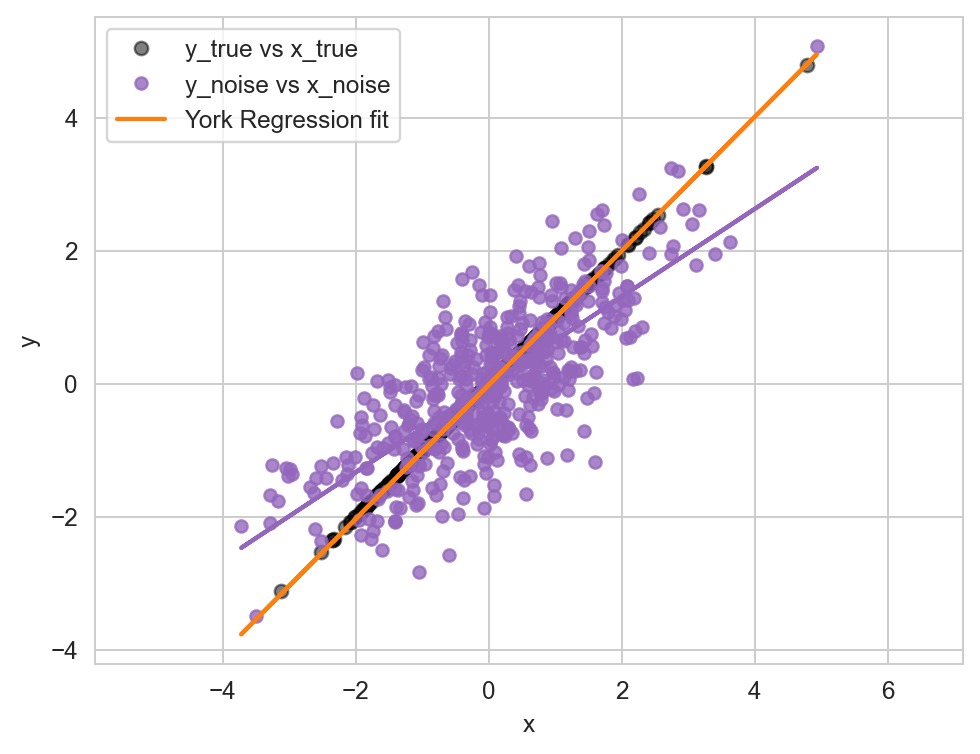

In [2]:
#---------------------------------------------------------------------------
np.random.seed(SEED)  # set random seed to get reproducible results
N = 500  # number of samples
slope_true = 1.0  # slope of the true best fit line
sigma_y = 0.44  # amplitude of y-error
sigma_x = 0.75  # amplitude of x-error
#---------------------------------------------------------------------------

# CREATE X DATA
x = np.random.normal(size=N)
x_noise = sigma_x*np.random.normal(size=len(x))
x_obs = x + x_noise

# CREATE Y DATA BASED ON X but with UNCORRELATED ERRORS
y = slope_true * x
y_noise = sigma_y*np.random.normal(size=len(x))
y_obs = y + y_noise

# FIT REGRESSION LINE
slope_xynoise, intercept_noise, __, __, __ = stats.linregress(x_obs,y_obs)
slope_xynoise = slope_xynoise.round(2)

# FIT YORK REGRESSION LINE
york_fit = LinReg(x_obs, sigma_x*np.ones(x_noise.shape), y_obs, sigma_y*np.ones(y.shape), rho=0.0)
york_slope = york_fit.slope

print(f"{slope_true = }")
print(f"est. {slope_xynoise = }")
print(f"est. {york_slope = }")

plt.figure()
plt.plot(x,y,'.', color="k", markersize=11, label=f"y_true vs x_true", alpha=.5)
plt.plot(x_obs, y_obs,'.', color="tab:purple", markersize=10, label=f"y_noise vs x_noise", alpha=.8)
plt.plot(x_obs, slope_xynoise*x_obs+intercept_noise, '-', color="tab:purple", linewidth=LW)
plt.plot(x_obs, x_obs*york_slope[0] + york_fit.intercept[0], '-', color='tab:orange', linewidth=LW, label='York Regression fit')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.axis('equal')
plt.show()


Now let's repeat this 10,000 times for lots of different data and best-fit lines. As we discussed in class, we can compute the theoretical average error that regression dilution will cause. Let's see if it works.

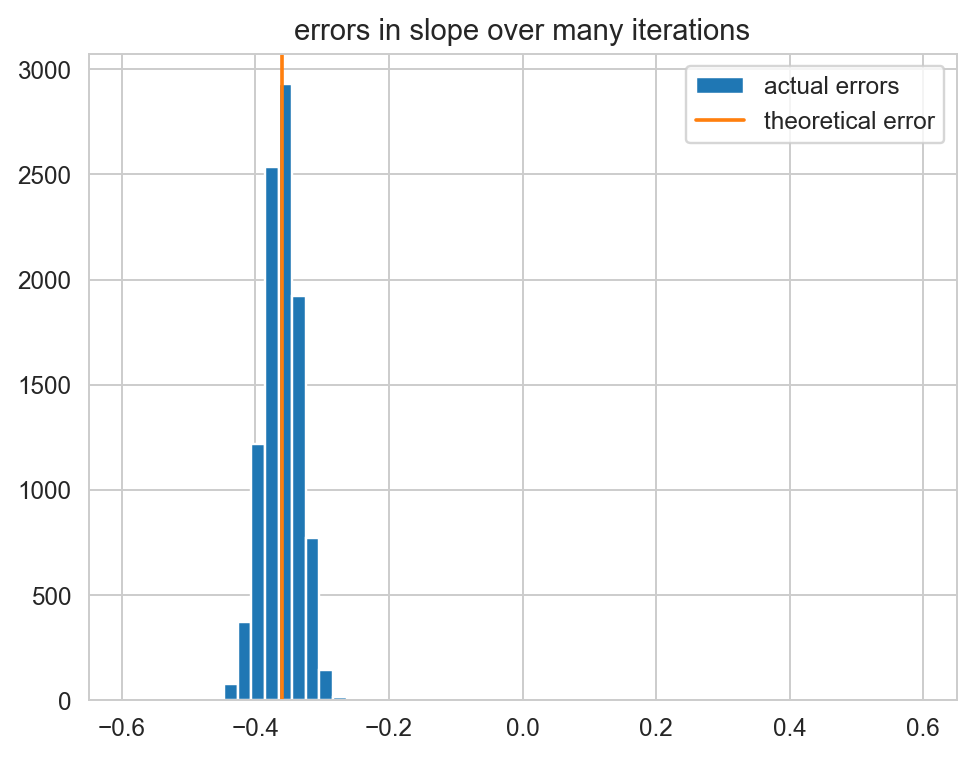

theoretical error = -0.36
average error     = -0.3602955100246391


In [3]:
#---------------------------------------------------------------------------
np.random.seed(SEED)  # set random seed to get reproducible results
N = 500  # number of samples
slope_true = 1.0  # slope of the true best fit line
y_error_amp = 0.44  # amplitude of y-error
x_error_amp = 0.75  # amplitude of x-error
niters = 10_000
#---------------------------------------------------------------------------

slope_vec = np.zeros((niters,))
for i in np.arange(0,niters):
    # CREATE TRUTH X DATA
    x = np.random.normal(size=N)

    # ONLY Y HAS NOISE
    y = slope_true * x
    y_noise = y_error_amp*np.random.normal(size=len(x))
    y_obs = y + y_noise

    # X AND Y BOTH HAVE UNCORRELATED NOISE
    x_noise = x_error_amp*np.random.normal(size=len(x))
    x_obs = x + x_noise
    slope_xynoise, intercept_noise, __, __, __ = stats.linregress(x_obs,y_obs)
    slope_vec [i] = slope_xynoise - slope_true

theory_error = -slope_true*(x_error_amp**2/(1**2 + x_error_amp**2))

plt.hist(slope_vec, label="actual errors")
plt.axvline(x=theory_error, color="tab:orange", label="theoretical error")
plt.title('errors in slope over many iterations')
plt.legend()
plt.xlim(-.65,.65)
plt.show()

print(f"theoretical error = {theory_error}")
print(f"average error     = {np.mean(slope_vec)}")

Wow! It definitely works. That is awesome.

# Correlated errors in x and y

Now, let's repeat the process but all the errors in x and the errors in y to be correlated with one another.

slope_true = 1.0
est. slope_xynoise = 0.56
est. york_slope = (1.0202711860930378, 0.049487994336184)


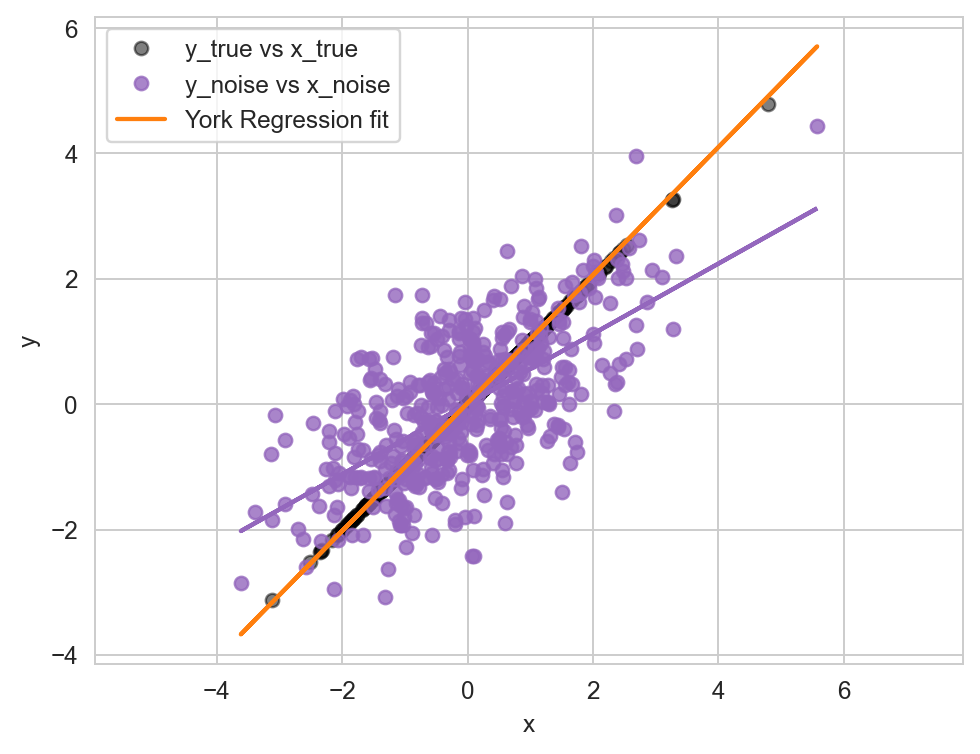

In [4]:
#---------------------------------------------------------------------------
LW = 1.75
np.random.seed(SEED)  # set random seed to get reproducible results
N = 500  # number of samples
r_xy = -.35  # correlation of x and y noise
slope_true = 1.0  # slope of the true best fit line
sigma_y = 0.44  # amplitude of y-error
sigma_x = 0.75  # amplitude of x-error
#---------------------------------------------------------------------------

# DEFINE THE CORRELATED NOISE
mean = [0, 0]
cov = [[sigma_x**2, r_xy*sigma_x*sigma_y], [r_xy*sigma_x*sigma_y, sigma_y**2]]
x_noise, y_noise = np.random.default_rng(SEED).multivariate_normal(mean, cov, N).T

# CREATE TRUTH X DATA
x = np.random.normal(size=N)
x_obs = x + x_noise

# ONLY Y HAS NOISE
y = slope_true * x
y_obs = y + y_noise

# X AND Y BOTH HAVE UNCORRELATED NOISE
slope_xynoise, intercept_noise, __, __, __ = stats.linregress(x_obs,y_obs)
slope_xynoise = slope_xynoise.round(2)

# YORK REGRESSION RESULT
york_fit = LinReg(x_obs, sigma_x*np.ones(x_obs.shape), y_obs, sigma_y*np.ones(y.shape), rho=r_xy)
york_slope = york_fit.slope

print(f"{slope_true = }")
print(f"est. {slope_xynoise = }")
print(f"est. {york_slope = }")

plt.figure()
plt.plot(x, y, '.', color="k", markersize=11, label=f"y_true vs x_true", alpha=.5)
plt.plot(x_obs, y_obs, '.', color="tab:purple", markersize=11, label=f"y_noise vs x_noise", alpha=.8)
plt.plot(x_obs, x_obs*slope_xynoise + intercept_noise, '-', color="tab:purple", linewidth=LW)
plt.plot(x_obs, x_obs*york_slope[0] + york_fit.intercept[0], '-', color='tab:orange', linewidth=LW, label='York Regression fit')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.axis('equal')
plt.show()


When the errors in x and y are correlated, York regression is essential for getting a good estimate of the slope. Unfortunately, this means you need to have an estimate of this correlation of the errors.

As above, let's check to see if our OLS-estimated slope has an error given by the equation in the notes.

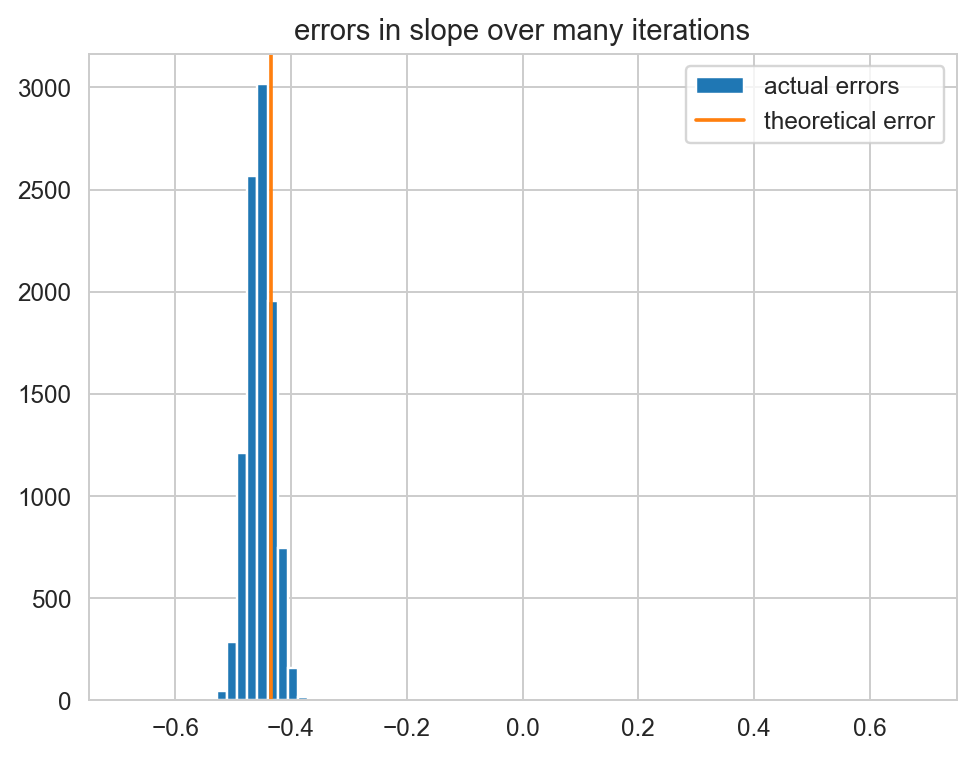

theoretical error = -0.43392
average error     = -0.4528297056886078


In [5]:
#---------------------------------------------------------------------------
LW = 1.75
np.random.seed(SEED)  # set random seed to get reproducible results
N = 500  # number of samples
r_xy = -.35  # correlation of x and y noise
slope_true = 1.0  # slope of the true best fit line
sigma_y = 0.44  # amplitude of y-error
sigma_x = 0.75  # amplitude of x-error
niters = 10_000
#---------------------------------------------------------------------------

slope_vec = np.zeros((niters,))
york_vec = np.zeros((niters,))
for i in np.arange(0,niters):
    # DEFINE THE CORRELATED NOISE
    mean = [0, 0]
    cov = [[sigma_x**2, r_xy*sigma_x*sigma_y], [r_xy*sigma_x*sigma_y, sigma_y**2]]
    x_noise, y_noise = np.random.default_rng(SEED).multivariate_normal(mean, cov, N).T

    # CREATE TRUTH X DATA
    x = np.random.normal(size=N)
    x_obs = x + x_noise

    # ONLY Y HAS NOISE
    y = slope_true * x
    y_obs = y + y_noise

    # X AND Y BOTH HAVE UNCORRELATED NOISE
    slope_xynoise, intercept_noise, __, __, __ = stats.linregress(x_obs,y_obs)
    slope_vec[i] = slope_xynoise - slope_true

theory_error = (r_xy) * np.sqrt( sigma_x**2 * sigma_y**2)/(1**2 + sigma_x**2) - slope_true*(sigma_x**2)/(1**2 + sigma_x**2)

plt.hist(slope_vec, label="actual errors")
plt.axvline(x=theory_error, color="tab:orange", label="theoretical error")
plt.title('errors in slope over many iterations')
plt.legend()
plt.xlim(-.75,.75)
plt.show()

print(f"theoretical error = {theory_error}")
print(f"average error     = {np.mean(slope_vec)}")

It works again!